In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = 1//2 * sum(p.^2)
V(q) = 1//2 * (q[1]^2 + q[2]^2 + 2q[1]^2 * q[2]- 2//3 * q[2]^3)
H(q, p) = T(p) + V(q)

function q̇(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function ṗ(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

const q0 = [0.1, 0.]
const p0 = [0., 0.5]
const u0 = hcat(q0, p0)
const E = H(q0, p0)

function g(u, resid)
    resid[1] = H([u[1],u[2]],[u[3],u[4]]) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13));

For the comparison we will use the following function

In [7]:
# energy_err(t,u1,u2,u3,u4) = (t, H([u1,u2], [u3,u4]) - E)
energy_err(sol) = map(i->H(hcat(sol[1,i], sol[2,i]), hcat(sol[3,i], sol[4,i]))-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]]) - E) for j=1:length(sol.u)]

function compare(; tmax=1e2)
    prob1 = DynamicalODEProblem(q̇, ṗ, q0, p0, (0., tmax))
    prob2 = ODEProblem(henon, u0, (0., tmax))
    @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    @time sol3 = solve(prob1, Vern9(), abstol=1e-14, reltol=1e-14)
    @time sol4 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    @time sol5 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    println("Vern9 + ManifoldProjection max energy error: ", maximum(abs_energy_err(sol1)))
    println("KahanLi8 max energy error: ",                   maximum(abs_energy_err(sol2)))
    println("Vern9 max energy error: ",                      maximum(abs_energy_err(sol3)))
    println("DPRKN12 max energy error: ",                    maximum(abs_energy_err(sol4)))
    println("TaylorMethod max energy error: ",               maximum(abs_energy_err(sol5)))
    
    plot(xlabel="t", ylabel="Energy error")
    plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8")
#     plot!(sol3, vars=(energy_err, 0,1,2,3,4), label="Vern9")
    plot!(sol3.t, energy_err(sol3), label="Vern9")
    plot!(sol4.t, energy_err(sol4), label="DPRKN12")
    plot!(sol5.t, energy_err(sol5) , label="TaylorMethod")
end

compare (generic function with 1 method)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

  0.007308 seconds (66.97 k allocations: 8.876 MiB)
  0.026238 seconds (190.21 k allocations: 10.319 MiB, 48.87% gc time)
  0.047422 seconds (1.58 M allocations: 26.838 MiB, 43.67% gc time)
  0.000800 seconds (9.00 k allocations: 407.922 KiB)
  0.050379 seconds (189.75 k allocations: 61.441 MiB, 68.78% gc time)
Vern9 + ManifoldProjection max energy error: 5.551115123125783e-16
KahanLi8 max energy error: 4.9404924595819466e-15
Vern9 max energy error: 1.4988010832439613e-15
DPRKN12 max energy error: 2.220446049250313e-15
TaylorMethod max energy error: 1.6653345369377348e-16



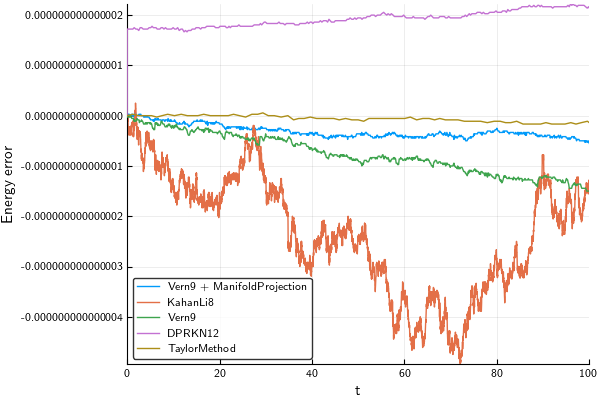

In [8]:
compare(tmax=1e2)

  0.493359 seconds (662.61 k allocations: 88.283 MiB, 84.59% gc time)
  0.264076 seconds (1.90 M allocations: 101.091 MiB, 56.75% gc time)
  0.829907 seconds (15.78 M allocations: 267.808 MiB, 68.96% gc time)
  0.006143 seconds (82.56 k allocations: 3.604 MiB)
  0.634082 seconds (1.88 M allocations: 268.962 MiB, 80.15% gc time)
Vern9 + ManifoldProjection max energy error: 5.578870698741412e-15
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15
TaylorMethod max energy error: 5.551115123125783e-16



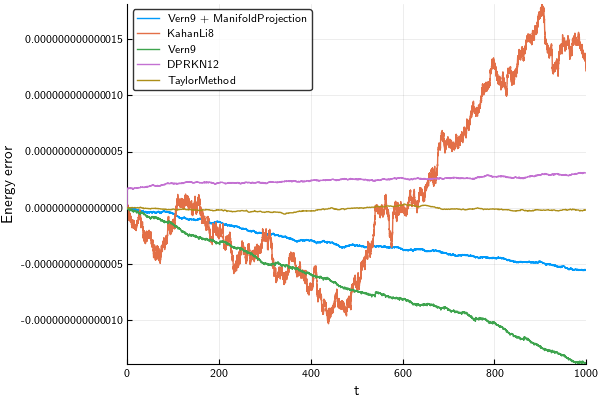

In [9]:
compare(tmax=1e3)

  1.752207 seconds (6.62 M allocations: 879.922 MiB, 58.15% gc time)
  2.702005 seconds (19.00 M allocations: 966.797 MiB, 51.78% gc time)
 11.800781 seconds (157.84 M allocations: 2.613 GiB, 73.75% gc time)
  0.129356 seconds (819.27 k allocations: 35.250 MiB, 52.53% gc time)
  3.233836 seconds (18.79 M allocations: 2.290 GiB, 59.60% gc time)
Vern9 + ManifoldProjection max energy error: 4.50195436485501e-14
KahanLi8 max energy error: 3.1585845050585704e-14
Vern9 max energy error: 1.22291066162461e-13
DPRKN12 max energy error: 1.607047828144914e-14
TaylorMethod max energy error: 2.7200464103316335e-15



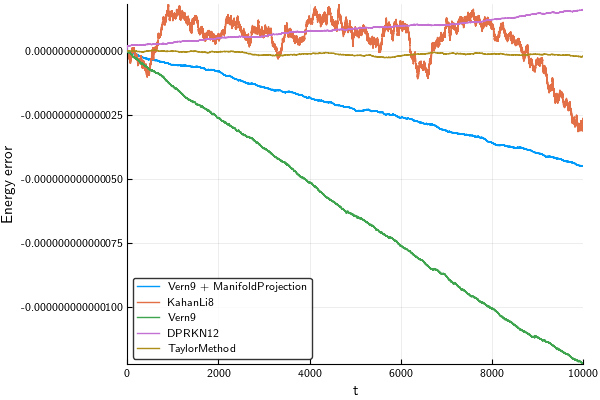

In [10]:
compare(tmax=1e4)

 13.069444 seconds (33.10 M allocations: 4.271 GiB, 71.33% gc time)
 21.818438 seconds (95.00 M allocations: 4.799 GiB, 73.14% gc time)
184.597284 seconds (789.20 M allocations: 13.041 GiB, 92.39% gc time)
  6.498975 seconds (4.09 M allocations: 178.146 MiB, 95.38% gc time)
 26.848736 seconds (93.93 M allocations: 11.300 GiB, 77.06% gc time)
Vern9 + ManifoldProjection max energy error: 9.997558336749535e-14
KahanLi8 max energy error: 1.2331802246023926e-13
Vern9 max energy error: 5.982436768192656e-13
DPRKN12 max energy error: 6.242228955954943e-14
TaylorMethod max energy error: 8.770761894538737e-15



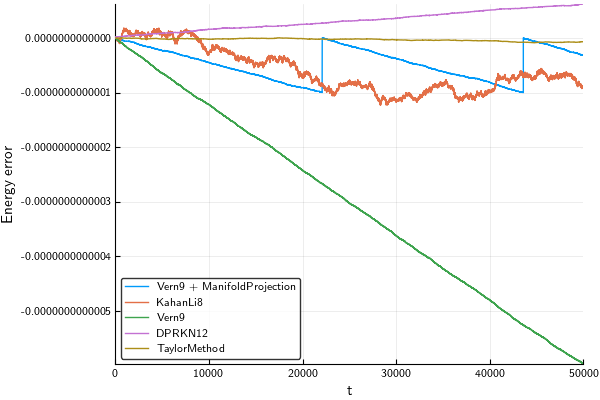

In [11]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable, but for smaller simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are relatively larger.